# COVID19 Inhibitory Peptide MD Analysis

## Introduction

This notebook is part of a project of reproducible analysis by the Structural Bioinformatics Group.

This analysis is based on the MD simulations of the binding of the SARS-CoV-2 spike protein (PDB:6LZG) with computationally designed peptide inhibitors.

Used libraries are matplotlib and seaborn for plotting, MDAnalysis for the analysis of the MD data, and nglview for protein visualization in the notebook.

In [84]:
import os
import MDAnalysis as mda     # This package is for MD Analysis
import nglview as nv         # This is a Jupyter PDB visualization
from MDAnalysis.analysis import contacts, distances
from matplotlib import animation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Example visualization

Data is stored into a topology file that contains the structure of the system, and a trajectory file for each run, we are going to load one at random to see the structure of the complex.

In [2]:
topology = './MD_DATA/2/step3_charmm2namd.psf'
trajectory = './MD_DATA/2/run1.xtc'
u = mda.Universe(topology, trajectory)

protein = u.select_atoms('protein')
w = nv.show_mdanalysis(protein)
w

NGLWidget(max_frame=1665)

Once we saw how is the Molecular Simulation of the Structure, let's check the segments inside of the atom universe.

# Generate the GIF and plots

Let's generate a loop in order to check the distances and generate the animation for all the runs. First a function that takes two groups of atoms and computes the matrix of distances and the number of contacts at each timeframe is generated.

First of all, we need to extract the residues of the interace between the S Protein and the ACE2.

## Interface Residues detection

First of all, let's load the PDB file with code 6LZG which contains the interaction between the S protein and the ACE2

In [25]:
u = mda.Universe("./6lzg.pdb")  
protein = u.select_atoms('protein')
w = nv.show_mdanalysis(protein)
w



NGLWidget()

In [ ]:
chains = [segment.segid for segment in protein.segments]
spike_ca = u.select_atoms('segid B and name CA and around 6 segid A')
residueinterface = [ "or resid " + str(atom.resid) for atom in spike_ca]

With this we defined the residues of the interface of the Spike protein that are within 6 amstrong of the ACE2 protein. We are going to use the identifier of these residues to extract the interace in the MD simulation.

In [68]:
def get_distances(u, groupA, groupB, radius):
    
    distance_series = list()
    num_contacts = list()
    
    for timestep in u.trajectory:
        dist = distances.distance_array(groupA.positions, groupB.positions)
        distance_series.append(dist)
        n_contacts = contacts.contact_matrix(dist, radius).sum()
        num_contacts.append([timestep.frame, n_contacts])
    
    contacts_df = pd.DataFrame(num_contacts, columns=["Timestep", "# Contacts"])
    
    return (contacts_df, distance_series)

Once it is done, we iterate over all the peptides and replicates in order to generate plots for each one of them. For this we generate a function that plots all the needed metrics based on the given files. Also, an extra funcion that generates an animation of the contact evolution.

In [82]:
def plot_md(model):
    
    numberofreplicates = 3
    
    f, axes = plt.subplots(3, 4, figsize=(40, 35))
    f.suptitle("Showing replicates for Peptide #{}".format(str(model)), fontsize=30, x=0.15, y=0.95)
    
    for replicate in range(1, numberofreplicates+1):
        
        topology = os.path.join("MD_DATA", str(model), "step3_charmm2namd.psf")
        trajectory = os.path.join("MD_DATA", str(model), "run{}.xtc".format(str(replicate)))
        u = mda.Universe(topology, trajectory)

        drug_ca = u.select_atoms('segid PROB and name CA')
        selection = 'segid PROA and name CA and ({})'.format(" ".join(residueinterface)[3:])
        spike_ca = u.select_atoms(selection)
        print (len(spike_ca))

        contacts_df, distance_series = get_distances(u, spike_ca, drug_ca, 7)

        sns.heatmap(distance_series[0], ax=axes[replicate-1,0], cmap=sns.cm.rocket_r, vmin=3, vmax=10)
        sns.heatmap(sum(distance_series)/len(distance_series), ax=axes[replicate-1,1], cmap=sns.cm.rocket_r, vmin=3, vmax=10)
        sns.heatmap(distance_series[-1], ax=axes[replicate-1,2], cmap=sns.cm.rocket_r, vmin=3, vmax=10)
        sns.lineplot(data=contacts_df, x="Timestep", y="# Contacts", ax=axes[replicate-1, 3])

        
        for index, label in zip(range(3), ["Start", "Average", "Final"]):
            axes[replicate-1,index].set_title(label, fontdict={'fontsize':26})
            axes[replicate-1,index].set_xticks(np.arange(0, len(drug_ca.residues), step=1))
            axes[replicate-1,index].set_xticklabels([str(residue)[9:-1] for residue in drug_ca.residues], rotation=45, fontsize=12)
            axes[replicate-1,index].set_yticks(np.arange(0, len(spike_ca.residues), step=1))
            axes[replicate-1,index].set_yticklabels([str(residue)[9:-1] for residue in spike_ca.residues],rotation=45, fontsize=12)
        axes[replicate-1,3].set_title("Number of contacts over time", fontdict={'fontsize':26})
        
    plt.savefig("./Results/model_{}.png".format(str(model)))
    return f.show()

In [90]:
def plot_animation(model):
    
    numberofreplicates = 1
    
    for replicate in range(1, numberofreplicates+1):
        
        topology = os.path.join("MD_DATA", str(model), "step3_charmm2namd.psf")
        trajectory = os.path.join("MD_DATA", str(model), "run{}.xtc".format(str(replicate)))
        u = mda.Universe(topology, trajectory)

        drug_ca = u.select_atoms('segid PROB and name CA')
        selection = 'segid PROA and name CA and ({})'.format(" ".join(residueinterface)[3:])
        spike_ca = u.select_atoms(selection)

        contacts_df, distance_series = get_distances(u, spike_ca, drug_ca, 7)
        
        fig, ax = plt.subplots()
        plt.ylabel("S Protein")
        plt.xlabel("Peptide")
        plt.title("Distance between residues")
        
        ax.set_xticks(np.arange(0, len(drug_ca.residues), step=1))
        ax.set_xticklabels([str(residue)[9:-1] for residue in drug_ca.residues], rotation=45, fontsize=12)
        ax.set_yticks(np.arange(0, len(spike_ca.residues), step=1))
        ax.set_yticklabels([str(residue)[9:-1] for residue in spike_ca.residues],rotation=45, fontsize=12)
        
        
        def animate(i):
            plt.imshow(distance_series[i], cmap="viridis_r", vmin=0, vmax=10)
        
        ani = animation.FuncAnimation(fig, animate, interval=200)
        ani.save("./Results/animations/Model_{}_rep_{}.gif".format(model, replicate), dpi=100, bitrate=30)


# Model Analysis

## Summary of the models:

Here we see summary of what happens with each one of the models, in order to gather the data into a quick view. Below will appear the plots for each one of the replicates for the models, being the first plot the initial conformation of the binding of the peptide, the second will be the average binding during all the timesteps, the third will be the final conformation of binding, and the last one will be the number of contacts at each timestep.

Model **14 and 18** have **no data**.

**Model 1, 6, 7, 8, 11, 15, 17:** Unbound.

**Model 2:** Stronger bind in two replicas. Unbound in the third.

**Model 3, 4, 16:** Stronger bind in one replica. Unbound in others.

**Model 5, 20:** One replica mantains bound, another changes binding site, another unbounds.

**Model 8: Best model overall, mantains the binding with same residues in the three replicas. In one of them it tries to unbound but it regains the binding.**

**Model 9: Second best model overall**

**Model 10, 12:** In the three replicas changes to a less stable conformation

**Model 13:** One replica lowers the binding energy, another one makes a better bound, and another one unbounds.

**Model 19:** Changes one conformation. Unbound in two replicas

In [ ]:
for model in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    plot_md(model)

MovieWriter ffmpeg unavailable; using Pillow instead.


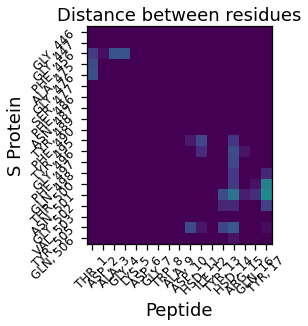

In [91]:
for model in [8]:#[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    plot_animation(model)